## Spark ALS Introduction 

**Author**: Christian S. Perone

**Email**: christian.perone@gmail.com

**Blog**: http://blog.christianperone.com 

# Importing packages

Here we are doing:
    
1. Making matplotlib plot inline
2. Import Numpy/Scipy/Pandas and Seaborn
3. Importing `findspark` (it will search for `SPARK_HOME` variable)
4. And finally importing PySpark modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
import pandas as pd

import seaborn as sns
sns.set(style="ticks")

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

np.random.seed(666)

# Loading dataset
Here we define our dataset filename and then we create a **Spark session**. Note that here you can load from hdfs, s3, hive and many different data sources.

In [2]:
MOVIELENS_SAMPLE = "sample_movielens_ratings.txt"
!head sample_movielens_ratings.txt

0::2::3::1424380312
0::3::1::1424380312
0::5::2::1424380312
0::9::4::1424380312
0::11::1::1424380312
0::12::2::1424380312
0::15::1::1424380312
0::17::1::1424380312
0::19::1::1424380312
0::21::1::1424380312


In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
rdd_lens = spark.read.text(MOVIELENS_SAMPLE).rdd

In [5]:
rdd_split = rdd_lens.map(lambda row: row.value.split("::"))

In [6]:
rdd_ratings = rdd_split.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                          rating=float(p[2]), timestamp=long(p[3])))

In [7]:
ratings = spark.createDataFrame(rdd_ratings)

In [8]:
ratings

DataFrame[movieId: bigint, rating: double, timestamp: bigint, userId: bigint]

In [9]:
ratings.printSchema()

root
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- userId: long (nullable = true)



In [10]:
ratings.show(n=10)

+-------+------+----------+------+
|movieId|rating| timestamp|userId|
+-------+------+----------+------+
|      2|   3.0|1424380312|     0|
|      3|   1.0|1424380312|     0|
|      5|   2.0|1424380312|     0|
|      9|   4.0|1424380312|     0|
|     11|   1.0|1424380312|     0|
|     12|   2.0|1424380312|     0|
|     15|   1.0|1424380312|     0|
|     17|   1.0|1424380312|     0|
|     19|   1.0|1424380312|     0|
|     21|   1.0|1424380312|     0|
+-------+------+----------+------+
only showing top 10 rows



In [11]:
ratings.count()

1501

In [12]:
ratings.is_cached

False

In [13]:
ratings.cache().count()

1501

In [14]:
ratings.is_cached

True

# Pandas Integration

PySpark also has integration with Pandas **DataFrame**.
However, note that once you convert your data to a Pandas DataFrame, all the data you selected will be loaded on **memory**, and these DataFrames are now Pandas DataFrames, without any interplay with Spark DataFrames.

In [15]:
small_sample = ratings.sample(False, 0.5, seed=666)

In [16]:
small_sample.count()

738

In [17]:
pandas_df = small_sample.toPandas()

In [18]:
pandas_df.head(5)

,movieId,rating,timestamp,userId
0,2,3,1424380312,0
1,5,2,1424380312,0
2,9,4,1424380312,0
3,11,1,1424380312,0
4,15,1,1424380312,0


In [19]:
pandas_df.describe()

,movieId,rating,timestamp,userId
count,738.000000,738.000000,738,738.000000
mean,48.112466,1.792683,1424380312,14.185637
std,28.243554,1.186354,0,8.496114
min,0.000000,1.000000,1424380312,0.000000
25%,24.000000,1.000000,1424380312,7.000000
50%,48.000000,1.000000,1424380312,14.000000
75%,71.000000,2.750000,1424380312,21.000000
max,99.000000,5.000000,1424380312,29.000000


In [20]:
pandas_df["rating"].value_counts()

1    457
3    101
2     96
4     49
5     35
dtype: int64

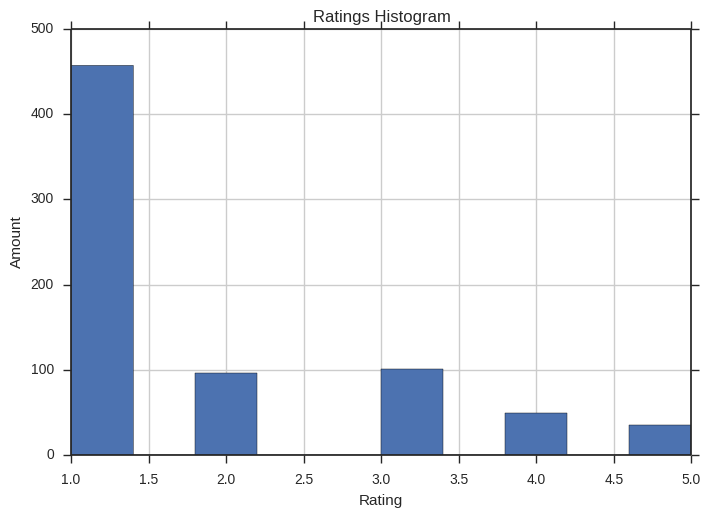

In [21]:
ax = pandas_df["rating"].hist()
ax.set_title("Ratings Histogram")
ax.set_xlabel("Rating")
ax.set_ylabel("Amount")

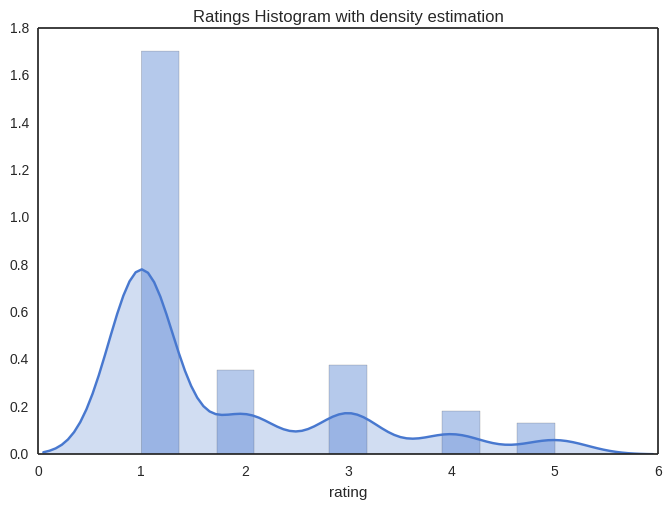

In [22]:
sns.set(style="white", palette="muted", color_codes=True)
ax = sns.distplot(pandas_df["rating"], hist=True, kde_kws={"shade": True})
ax.set_title("Ratings Histogram with density estimation")

In [23]:
pandas_df["userId"].nunique()

30

In [24]:
pandas_df["movieId"].nunique()

100

In [25]:
pivot_user_movie = pandas_df.pivot("userId", "movieId", "rating")

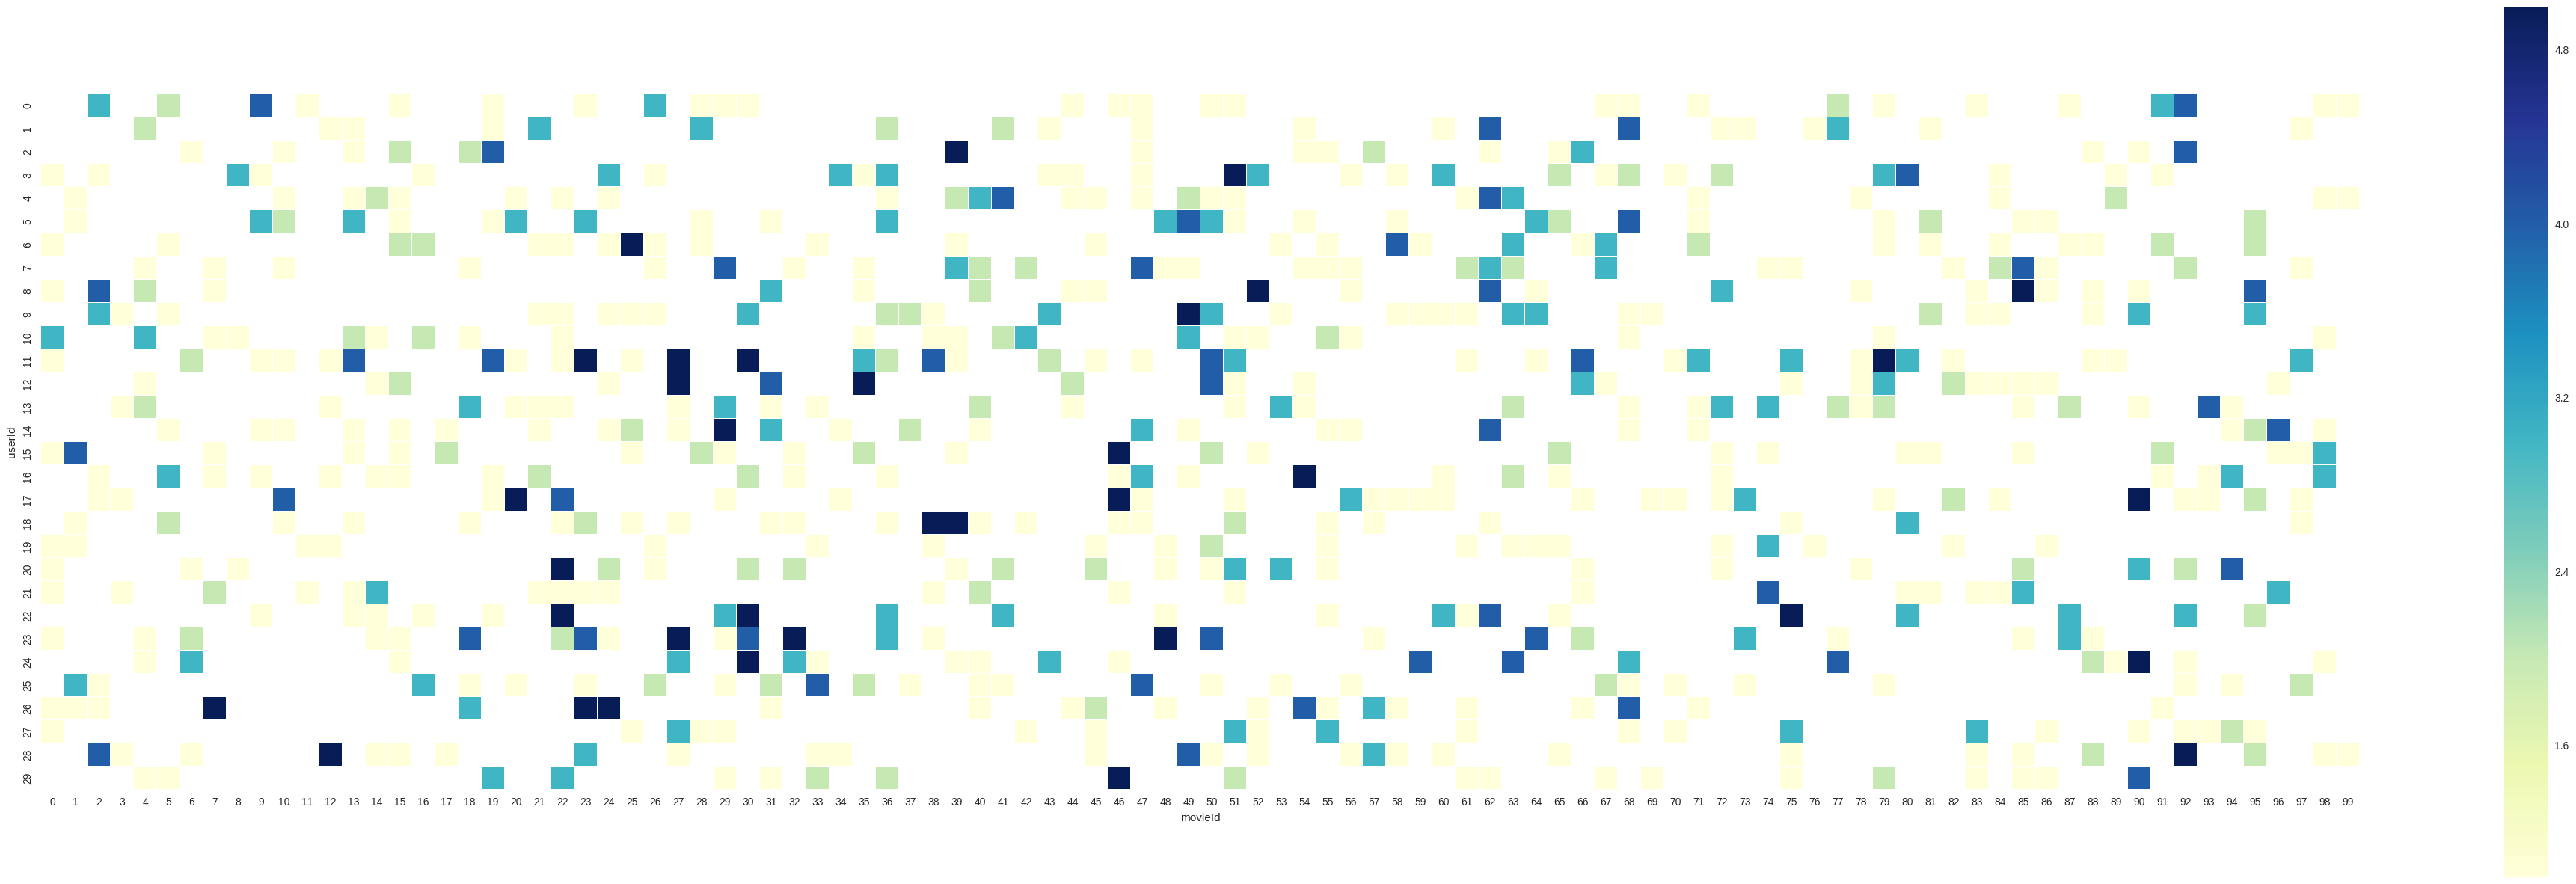

In [26]:
plt.figure(figsize=(50, 15))
sns.heatmap(pivot_user_movie, linewidths=.2, cmap="YlGnBu", square=True)

# Spark SQL

In [27]:
spark.catalog.listTables()

[]

In [28]:
ratings.createOrReplaceTempView("ratings")

In [29]:
only_user5 = spark.sql("select movieId, rating from ratings where userId == 5")

In [30]:
only_user5.show(n=5)

+-------+------+
|movieId|rating|
+-------+------+
|      0|   1.0|
|      1|   1.0|
|      4|   1.0|
|      5|   1.0|
|      8|   1.0|
+-------+------+
only showing top 5 rows



In [31]:
user5_avg = spark.sql("select avg(rating) from ratings where userId == 5")

In [32]:
user5_avg.show()

+------------------+
|       avg(rating)|
+------------------+
|1.7755102040816326|
+------------------+



# Train / Test Split and Training

In [33]:
(training, test) = ratings.randomSplit([0.8, 0.2], seed=666)

In [34]:
training.count()

1183

In [35]:
test.count()

318

Here we will instantiate the ALS class, that will provide Alternating Least Squares optimization for the model below:

$min_{x,y}\sum_{u,i}(r_{ui} - x_{u}^{T} y_i)^2 + \lambda(\sum_{u} \lVert x_u \rVert^2 + \sum_{i} \lVert y_i \rVert^2)$ (*bias omitted*)

Actually, ALS on Spark uses ALS-WR (ALS with weighted-$\lambda$-regularization), where there are two weights that are used on the norms. More information at <http://www.grappa.univ-lille3.fr/~mary/cours/stats/centrale/reco/paper/MatrixFactorizationALS.pdf>

In [36]:
als = ALS(maxIter=5, regParam=0.01, userCol="userId",
          itemCol="movieId", ratingCol="rating")

In [37]:
model = als.fit(training)

In [38]:
predictions = model.transform(test)

In [39]:
predictions.printSchema()

root
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- userId: long (nullable = true)
 |-- prediction: float (nullable = true)



In [40]:
test.show(5)

+-------+------+----------+------+
|movieId|rating| timestamp|userId|
+-------+------+----------+------+
|      0|   1.0|1424380312|    13|
|      1|   1.0|1424380312|     4|
|      1|   1.0|1424380312|     6|
|      2|   1.0|1424380312|    19|
|      3|   1.0|1424380312|    17|
+-------+------+----------+------+
only showing top 5 rows



In [41]:
predictions.show(5)

+-------+------+----------+------+----------+
|movieId|rating| timestamp|userId|prediction|
+-------+------+----------+------+----------+
|     31|   1.0|1424380312|     5|-0.4402875|
|     31|   3.0|1424380312|     8| 3.7286339|
|     65|   2.0|1424380312|     3| 2.6136785|
|     65|   1.0|1424380312|    24|0.69356513|
|     53|   2.0|1424380312|    19| 0.8822904|
+-------+------+----------+------+----------+
only showing top 5 rows



In [42]:
model.userFactors

DataFrame[id: int, features: array<float>]

In [43]:
model.itemFactors

DataFrame[id: int, features: array<float>]

In [44]:
user_features = model.userFactors.filter("id==23").first()
item_features = model.itemFactors.filter("id==2").first()

In [45]:
item_features = np.array(item_features.features)
user_features = np.array(user_features.features)

In [46]:
item_features

array([ 1.70997763,  1.28560305,  0.42418408, -0.82950467,  0.89465541,
        1.680076  ,  3.17149854, -1.78555119,  2.99750376,  0.35579562])

In [47]:
user_features

array([ 0.51132232, -0.137623  ,  0.62162256, -0.01336355, -0.12120036,
        0.62251639,  0.43826899,  0.08257401, -0.60342747, -0.1455662 ])

In [48]:
np.dot(user_features, item_features)

1.2915924136464523

# Model Evaluation
Here, we'll use the metric RMSE (Root Mean Square Error) do evaluate the performance of your predictions.

RMSE = ${\sqrt {\frac{1} {N}{\sum\limits_{i = 1}^N {(c_{i} - \bar{c}_{i} } })^{2} } }$


In [49]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [50]:
rmse = evaluator.evaluate(predictions)

In [51]:
print "RMSE: {:.6f}".format(rmse)

RMSE: 1.857842
